In [ ]:
# Libraries
import yfinance as yf
from datetime import datetime
import requests
import numpy as np
import pandas as pd
from scipy.stats import norm
from typing import Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.simplefilter("ignore")

# Aux. Functions

In [ ]:
def download_ibov_data(ticker='BOVA11.SA', start='2019-01-01', end=None):
    data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust = True)
    data = data.xs((ticker), level="Ticker", axis=1)['Close'].to_frame()
    data['Returns'] = data.pct_change()
    data['Log Returns'] = np.log(1 + data['Returns'])
    return data.dropna()

def get_selic(code = 1178):
    # Brazilian Central Bank Time Series Management System:
    # SELIC (p.d.)          code : 11
    # SELIC (p.y.)          code : 1178
    # SELIC target (p.y.)   code : 432

    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{code}/dados/ultimos/1?formato=json"

    # Fetch data
    response = requests.get(url)
    data = response.json()

    # Extract the latest SELIC value (in %)
    selic_value = float(data[0]['valor'])

    return selic_value/100


def get_options_data(ticker)-> Tuple[pd.DataFrame, np.ndarray]:
    """
    Parameters:
      ticker  : Underlying asset ticker

    Return    : Dataframe with options data from opcoes.net.br
              : List of available maturities

    """
    url = f'https://opcoes.net.br/listaopcoes/completa?idAcao={ticker}&listarVencimentos=true&cotacoes=true'
    response = requests.get(url, verify=False).json()

    ## List of option expiration dates
    exp_dates = [date['value'] for date in response['data']['vencimentos']]


    options = []
    ## Get the options for each exp. date
    for exp in exp_dates:
      url=f'https://opcoes.net.br/listaopcoes/completa?idAcao={ticker}&listarVencimentos=false&cotacoes=true&vencimentos={exp}'
      response = requests.get(url).json()

      if response['success']:
        options += [[ticker, exp, info[0].split('_')[0], info[2], info[3], info[5], info[8]] for info in response['data']['cotacoesOpcoes']]
               ## info[0]  : Option ticker
               ## info[2]  : Option type [CALL, PUT]
               ## info[3]  : Option Expiration type [A, E] (American or European)
               ## info[5]  : Option Strike
               ## info[8]  : Option last price
      else:
        print(f'Expiration: {exp} failed!')

    ## Build a DataFrame
    columns = ['Underlying','Expiration','Opt Ticker', 'Type', 'Type Exp', 'Strike', 'Price']
    options = pd.DataFrame(options, columns=columns)
    options['Expiration'] = pd.to_datetime(options['Expiration'], errors='coerce')

    return options, exp_dates



def black_scholes_price(S, K, T, r, sigma, op_type):
    """
    Parameters:
      S       : Asset price
      K       : Strike price
      T       : Time to maturity
      r       : risk-free rate
      sigma   : volatility
      op_type : 'CALL' or 'PUT'

    Return    : Option price

    """

    ## Cumulative distribution function of the standard normal distribution
    N = norm.cdf

    ## Black-Scholes Formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)


    ## Check the option type and compute the payoff
    if op_type == 'CALL':
        op_price = S * N(d1) - N(d2) * K * np.exp(-r * T)
    elif op_type == 'PUT':
        op_price = K * np.exp(-r * T) * N(-d2) - S * N(-d1)
    else:
        raise ValueError("op_type must be 'CALL' or 'PUT'!")

    return op_price


def implied_volatility_bisection(P, op_type, S, K, T, r, tol=1e-4, max_iter=200):
    """
    Compute implied volatility using the bisection method.

    Parameters:
      P        : Observed option price
      op_type  : 'CALL' or 'PUT'
      S        : Asset price
      K        : Strike
      T        : Time to Maturity
      r        : Risk-free rate
      tol      : Error tolerance
      max_iter : Max iterations for bisection

    Return:
      Implied volatility (%) or np.nan if not converged
    """
    if T == 0:
        return 0

    # Initial bounds
    lower_bound, upper_bound = 1e-6, 5

    for _ in range(max_iter):
        sigma = (lower_bound + upper_bound) / 2
        price = black_scholes_price(S, K, T, r, sigma, op_type)

        if abs(price - P) < tol:
            return sigma

        if price > P:
            upper_bound = sigma
        else:
            lower_bound = sigma

    return np.nan  # Not converged


# Load Data

## IBOV (BOVA11) spot data

In [ ]:
# Creating DataFrame of IBOV returns
ibov_df = download_ibov_data()

# Compute rolling std using a 252-day window (1 trading year)
ibov_df['Rolling std'] = ibov_df['Log Returns'].rolling(window=252).std().bfill()
bova_last_price = ibov_df['Close'][-1]

print(f"The last price of BOVA11 is: R$ {bova_last_price:.2f}")

The last price of BOVA11 is: R$ 129.24


In [ ]:
ibov_df

,Close,Returns,Log Returns,Rolling std
Date,,,,
2019-01-03,88.000000,0.001138,0.001137,0.011709
2019-01-04,88.500000,0.005682,0.005666,0.011709
2019-01-07,88.480003,-0.000226,-0.000226,0.011709
2019-01-08,88.830002,0.003956,0.003948,0.011709
2019-01-09,90.320000,0.016774,0.016634,0.011709
...,...,...,...,...
2025-03-20,128.850006,-0.005787,-0.005804,0.009128
2025-03-21,128.979996,0.001009,0.001008,0.009122
2025-03-24,128.190002,-0.006125,-0.006144,0.009090


## Option Data


In [ ]:
bova_options, exp_dates = get_options_data('BOVA11')

## Selecting only European options
bova_euro_options = bova_options[bova_options['Type Exp'] == 'E'].copy().dropna().reset_index(drop=True)
bova_euro_options.head()

,Underlying,Expiration,Opt Ticker,Type,Type Exp,Strike,Price
0,BOVA11,2025-03-28,BOVAC101W4,CALL,E,101.0,27.85
1,BOVA11,2025-03-28,BOVAC103W4,CALL,E,103.0,26.15
2,BOVA11,2025-03-28,BOVAC105W4,CALL,E,105.0,24.13
3,BOVA11,2025-03-28,BOVAC107W4,CALL,E,107.0,22.22
4,BOVA11,2025-03-28,BOVAC109W4,CALL,E,109.0,19.10


In [ ]:
## Compute time to maturity (TTM) in years
bova_euro_options['TTM'] = np.where(
    bova_euro_options['Expiration'].dt.date <= datetime.now().date(),  # Condition
    0,  # If today is the expiration day
    (bova_euro_options['Expiration'] - datetime.now()).dt.days / 252  # Otherwise, compute TTM in years
)

# Risk-free rate from BCB
r = get_selic()

## Compute implied volatility from market prices
bova_euro_options['Implied Vol'] = bova_euro_options.apply(
    lambda row: implied_volatility_bisection( P=row['Price'],
                                    S=bova_last_price,
                                    op_type=row['Type'],
                                    K=row['Strike'],
                                    T=row['TTM'],
                                    r= r),
    axis=1
)


bova_euro_options = bova_euro_options.dropna()
bova_euro_options['Expiration'].value_counts().sort_index()

,count
Expiration,
2025-03-28,54
2025-04-04,48
2025-04-11,37
2025-04-17,131
2025-04-25,13
2025-05-02,5
2025-05-09,5
2025-05-16,120
2025-06-20,69


## Saving DataFrames as pkl

In [ ]:
bova_euro_options.to_pickle("bova_euro_options.pkl")
ibov_df.to_pickle("ibov_df.pkl")

bova_euro_options.head(10)

,Underlying,Expiration,Opt Ticker,Type,Type Exp,Strike,Price,TTM,Implied Vol
6,BOVA11,2025-03-28,BOVAC113W4,CALL,E,113.0,16.64,0.003968,1.445618
8,BOVA11,2025-03-28,BOVAC117W4,CALL,E,117.0,12.34,0.003968,0.745850
14,BOVA11,2025-03-28,BOVAC129W4,CALL,E,129.0,0.75,0.003968,0.178910
15,BOVA11,2025-03-28,BOVAC131W4,CALL,E,131.0,0.17,0.003968,0.220185
16,BOVA11,2025-03-28,BOVAC133W4,CALL,E,133.0,0.04,0.003968,0.263062
17,BOVA11,2025-03-28,BOVAC135W4,CALL,E,135.0,0.01,0.003968,0.300904
18,BOVA11,2025-03-28,BOVAC137W4,CALL,E,137.0,0.01,0.003968,0.388185
19,BOVA11,2025-03-28,BOVAC139W4,CALL,E,139.0,0.01,0.003968,0.472413
20,BOVA11,2025-03-28,BOVAC141W4,CALL,E,141.0,0.02,0.003968,0.603028
21,BOVA11,2025-03-28,BOVAC143W4,CALL,E,143.0,0.01,0.003968,0.632325


## Plotting Volatility Smile

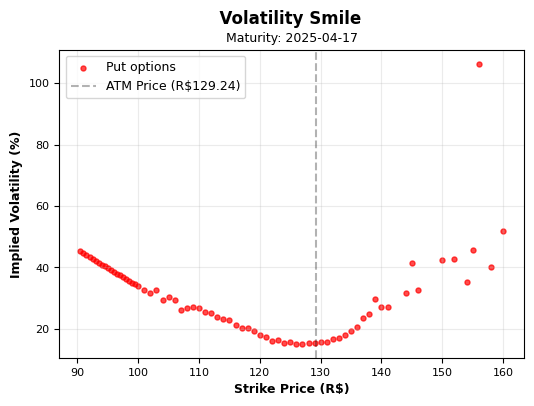

In [ ]:
## Chose Maturity
mat = '2025-04-17'
options = bova_euro_options[bova_euro_options['Expiration'] == mat].copy().reset_index(drop=True)

## Dividing put and call options
df_put  = options[options['Type'] == 'PUT'].copy().reset_index(drop=True)
df_call  = options[options['Type'] == 'CALL'].copy().reset_index(drop=True)

## Create figure and axis
fig, ax = plt.subplots(figsize=(6,4))

## Selecting closer range strikes to plot
df_plot = df_put[ df_put["Strike"] > (bova_last_price * 0.7)] # Filter out lower strikes
df_plot = df_plot[ df_plot["Strike"] < (bova_last_price * 1.3)] # Filter out higher strikes

## Add puts
ax.scatter(df_plot["Strike"], df_plot["Implied Vol"]*100, s=13,color="red", label='Put options', alpha=0.7)

## Add ATM price line
ax.axvline(x=bova_last_price, color="black", linestyle="--", label=f"ATM Price (R${bova_last_price:.2f})", alpha = 0.3)

## Customizing axis
ax.set_xlabel("Strike Price (R$)", fontsize=9, fontweight='semibold')
plt.xticks(fontsize=8)
ax.set_ylabel("Implied Volatility (%)", fontsize=9, fontweight='semibold')
plt.yticks(fontsize=8)
#plt.ylim(10,60)

## Customizing plot
plt.suptitle("  Volatility Smile", fontweight='bold' )
plt.title(f"Maturity: {mat}", fontsize=9)
ax.legend(fontsize=9, loc='upper left')
ax.grid(alpha=0.25)

## Show plot
plt.show()